In [2]:
import os
import re
def DIR2lasti(DIR,pattern='seed(\d+)_size600'):
    dlst = os.listdir(DIR)
    dlst = ''.join(dlst)
    it = re.findall(pattern,dlst)
    lasti = max(map(int,it))
    return lasti
DIR = 'data_rand/'

import numpy as np
fs = [x for x in os.listdir(DIR,) if x.startswith('seed')]
idx = re.findall('seed(\d+)_',''.join(fs))
# fs = sorted
fs = np.take(fs,np.argsort(np.array(idx,int)))
out = sum((np.load(os.path.join(DIR,f)).tolist()  for f in fs),[])
print len(fs)
print fs[:10]


# %%time
# %matplotlib notebook
from pymisca.util import *
from pymisca.vis_util import *
import IPython.display as ipd

import KBs
import random
import workers
reload(workers)

tst_dct = KBs.tst_dct
try:
    tst_out = np.load('%s/reference.npy'%DIR,).tolist()
except:
    tst_out = mp_map(workers.worker0325,tst_dct,n_cpu=6)
    np.save('%s/reference.npy'%DIR,tst_out)
print 'finished'

905
['seed0_size40.npy' 'seed1_size40.npy' 'seed2_size40.npy'
 'seed3_size40.npy' 'seed4_size40.npy' 'seed5_size40.npy'
 'seed6_size40.npy' 'seed7_size40.npy' 'seed8_size40.npy'
 'seed9_size40.npy']
is in ipython: 1
[WARN] pymisca.vis_util cannot find network
finished


In [17]:
#     idx = np.meshgrid(range(L),range(L))
#     idx = zip(*[x.ravel() for x in idx])
idx =list(itertools.product(range(L),range(L)))
mut = mutate(ini,idx)


In [727]:

# if 1:    
#     loc = np.vstack([
# #         [0]*nsp,
#                      range(0,nsp),
#                     zip(*idx)]
#                    )
#     idx = np.ravel_multi_index(loc, (nsp,)+ini.shape[1:] )  
def idx_square(ini):
    L = ini.shape[-1]
    idx =list(itertools.product(range(L),range(L)))
    return idx
def dmat_l1(ini,idx=None):
    L = ini.shape[-1]
    if idx is None:
        idx =list(itertools.product(range(L),range(L)))
    X = np.arange(0,L)
    X = np.minimum(L-X,X)
    X = abs(X)
    X,Y = np.meshgrid(X,X)
    D =  X+Y
    D0 = D[None,None]
    Dmat = np.concatenate([np.roll(D0,x ,axis=(-2,-1)) for x in idx],axis=1)
    return Dmat


def worker(dct):
    env = guess(dct=dct)
    env.change_size((20, 100, 30**2))
    hist = sample(env)
    ini = hist[-1,0:1]

    # L = ini.shape[-1]
    # nsp = len(idx)
    idx= idx_square(ini)
    mut = mutate(ini,idx)
    Dmat = dmat_l1(ini)

    out = sample(env,ini=mut)
    out = out[:20]
    real = out[:,0:1]
    SUM = out[:,1:] + real

    ###short name for defect
    defect = SUM==1
    pop = np.sum(defect,axis=(-1,-2))
    drift = np.sum(defect*Dmat,axis=(-1,-2))
    return pop,drift,real,defect
#     return pop,drift,real

def plotter(pop,worker):
    N = 300
    xs = pop[:,:N]
    ys = drift[:,:N]
    fig,axs = plt.subplots(1,2,figsize=[12,4])
    plt.sca(axs[0])
    plt.plot(xs,ys,alpha=0.1)
    xs = pop[-1,:].ravel()
    ys = drift[-1,:].ravel()
    plt.scatter(xs,ys,1,marker='o')
    plt.scatter(xs.mean(),ys.mean(),10,marker='x',color='red')
    xlim = -5,600
    ylim = -10,6000

    plt.xlim(xlim)
    plt.ylim(ylim)
#     plt.xscale('log')
    plt.title('P(pop=0)=%.4f'%(np.mean(pop[-1]<10))
             +'\n slope=%.2E'%(ys.mean()/xs.mean()))
    plt.grid()
    xs = pop[:,:]
    ys = drift[:,:]
    cts,xedge,yedge = np.histogram2d(
        xs.ravel(),ys.ravel(),
              bins=(np.linspace(*(xlim+(40,))),
                np.linspace(*(ylim+(40,)))),
    )
    plt.sca(axs[1])
    plt.pcolormesh(xedge,yedge,np.log(cts+1).T)
#     plt.hist2d(xs.ravel(),ys.ravel(),
#               bins=(np.linspace(*(xlim+(40,))),
#                 np.linspace(*(ylim+(40,)))),
#               )
    plt.xlim(xlim)
    plt.ylim(ylim)
#     plt.xscale('log')
    plt.grid()
# tSUM = (flaw).mean(axis=0)
# Dmat = dmat_l1(ini)
#     plt.plot(*(idx[20]+('x',)))
#     plt.show()

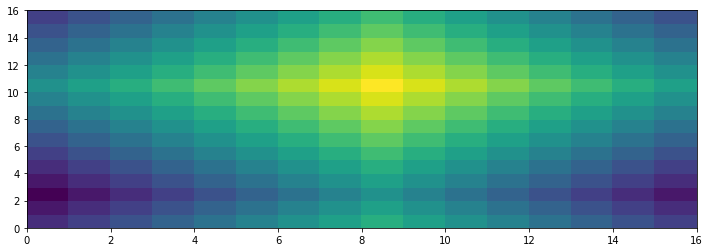

In [725]:
showsptime(Dmat[0,2])

plt.show()    

In [736]:
# def wrapper(init,sc)
idx= idx_square(ini)
Dmat = dmat_l1(ini)
SHAPE = ini.shape
# env.change_size((20, 20, 30**2))
def scorer(IN,cue=0):
    ini = np.reshape(IN,SHAPE)
    mut = mutate(ini,idx)    
    out = sample(env,ini=mut)
#     out = out[:20]
    real = out[:,0:1]
    mutout = out[:,1:]
    SUM = mutout + real

    ###short name for defect
    defect = SUM==1
    pop = np.sum(defect,axis=(-1,-2))
    drift = np.sum(defect*Dmat,axis=(-1,-2))
    mask = drift[-1]>15
#     score = - (drift[-1][mask]/pop[-1][mask]).mean()
# #     score = - np.log(drift[-1][mask].mean()/pop[-1][mask].mean())
# #     score = - drift[-1].mean()/pop[-1].mean() * drift[-1].std()

#     score = - np.log(drift[-1][mask].mean()/pop[-1][mask].mean())
    score = drift[-1][mask].mean()-10*pop[-1][mask].mean()
#     score = drift[-1][mask].mean()/pop[-1][mask].mean()
    score = -score

    
#     d = spdist.pdist(sflatten(out[-1]),'hamming')
    
#     print out.shape
#     print sflatten(out[-1]).shape

#     D = spdist.squareform(d)    
#     STD = D.std(axis=0)

    if cue:
        return drift[-1] - 10*pop[-1]
#         return STD[1:]

#     score = -STD.mean() 
#     score +=  ini.mean()*2
#     print score
#     print 'test'
    return score
def print_fun(x, f, accepted):
    print("at minima %.4f accepted %d" % (f, int(accepted)))
def take_step(ini):
    out = ini.copy()
    r = random.randrange(ini.size)
    out.flat[r] = 1 - out.flat[r]
    return out

import scipy.optimize as spopt
# res = spopt.basinhopping(scorer,ini,take_step=take_step,niter=1,T=0.5,minimizer_kwargs={'method':'Nelder-Mead'}
#                         , callback=print_fun)
# print (scorer(ini,cue=1).shape)

In [703]:
env = guess(dct=tst_dct[32])
# env = guess(dct = {'family':'2dntca','rulestr':})
# env = CA_sys()
# env.alias='B3ai4ac7/S3i4a5ai6ac7c8'
# env.alias2rulestr()
env.change_size((50, 30, 16**2))
hist = sample(env)
ini = hist[0][0:1]
# SHAPE = hist[0][0:1].shape
print SHAPE
it = hist[0]
# ini = it
# print it.shape
res = map(scorer,it)

 (1, 16, 16)


In [678]:
# res

In [693]:
import math
def take_step(ini):
    out = ini.copy()
#     r = random.randrange(ini.size)
    r = np.random.randint( ini.size,size=10)
    new = np.random.random()<0.5
    out.flat[r] = new
#     out.flat[r] = 1 - out.flat[r]
    return out
def descent(scorer,ini,take_step,niter=100,T=1.):
    T0 = float(T)
    f0 = scorer(ini)
    old = ini
    r = np.random.random(niter)
    for i in range(niter):
        new = take_step(old)
        f1 = scorer(new)
        if f1 -f0 < 0:
            update = 1
        else:
            T = (i*0 + (niter-i)*T0)/niter
            p = math.exp(-(f1-f0)/T)
            update = r[i] < p
        if update:
            old = new
            f0  = f1 
    return old

    
# o = descent(scorer,it[0],take_step,niter=50)

 {'alias': 'b3aceijknqrys3aceijknqry2aceikn', 'rulestr': u'000000000060031c61c67f86a0', 'family': '2dntca'}
1b2o4b3o2b1o1b1o1b$1o7b1o3b2o2b$1b3o5b3o4b$1b1o4b1o1b1o4b1o1b1o$1b1o1b1o2b1o1b1o2b1o2b1o1b$2b1o2b1o4b6o$2b1o1b1o1b1o1b2o5b1o$2b1o1b3o2b1o1b2o3b$2b2o2b1o2b1o1b1o1b1o2b$3o1b1o1b1o3b1o2b1o2b$1b1o6b1o2b1o1b1o2b$1o1b1o1b1o1b2o2b4o2b$1o2b1o1b4o1b1o1b1o3b$2b1o3b3o1b2o4b$1o4b1o1b3o3b2o1b$1b1o1b1o1b2o1b1o3b1o1b1o1b


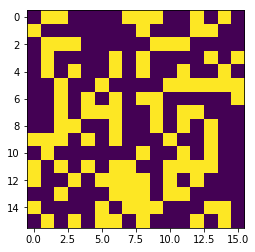

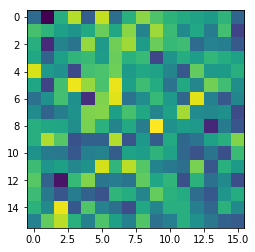

In [742]:
im = it[0]
print env.as_config()
print gollyrle(im)
plt.imshow(im)
plt.show()
plt.imshow(sexpand(scorer(im,cue=1)[None,:])[0])
plt.show()

In [697]:
out = hist[0][0]

In [ ]:
x = 10, y = 1, rule = B3/S23:T10,10
o2b3ob3o!


logged 68.82426778242677
logged 68.82426778242677
logged 68.82426778242677
logged 68.82426778242677
logged 68.82426778242677
logged 68.82426778242677
logged 68.82426778242677
logged 68.14830508474574
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785


logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785


logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785


logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785


logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785


logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785


logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
logged 67.81092436974785
67.81092436974785
{'alias': 'b3aceijknqrys3aceijknqry2aceikn', 'rulestr': u'000000000060031c61c67f86a0', 'family': '2dntca'}
1o3b3o2b1o2b1o1b1o1b$1o3b1o1b3o1b1o2b3o$1o1b1o6b3o2b1o1b$1o4b2o1b2o1b1o2b2o

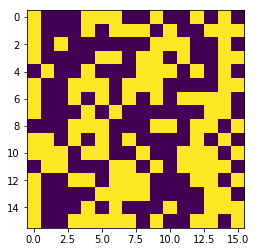

In [743]:
for i in range(2000):
    print 'logged',
    print scorer(out)
    out = descent(scorer,out,take_step,niter=50,T=0.005)
o = out
plt.imshow(o)
print scorer(o)
print env.as_config()
print gollyrle(o)
plt.show()

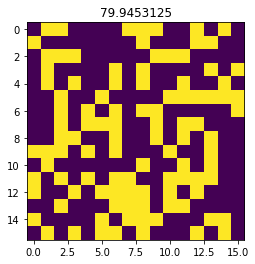

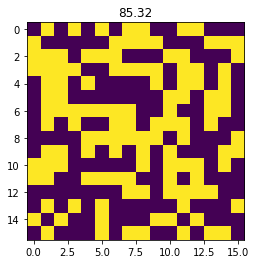

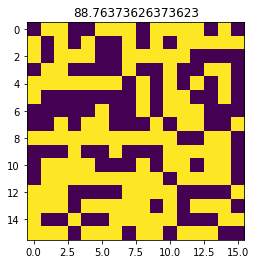

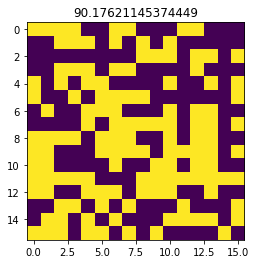

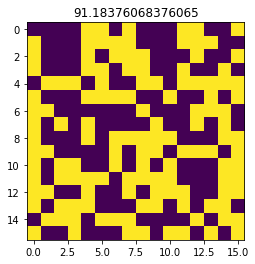

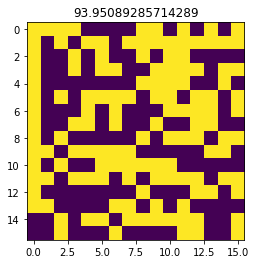

In [739]:
it = hist[-1]
it = hist[0]
# ini = it
# print it.shape
res = map(scorer,it)

# it = hist[-1]
order = np.argsort(res)
it = np.take(it,order,axis=0)

for i,pt in list(enumerate(it))[:6]:
# for i,pt in list(enumerate(it))[-6:]:
    plt.imshow(pt)
    plt.title(res[order[i]])
    plt.show()

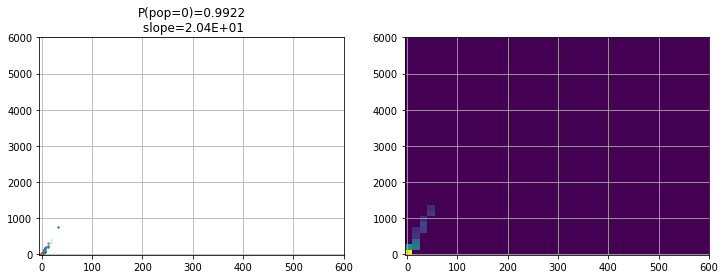

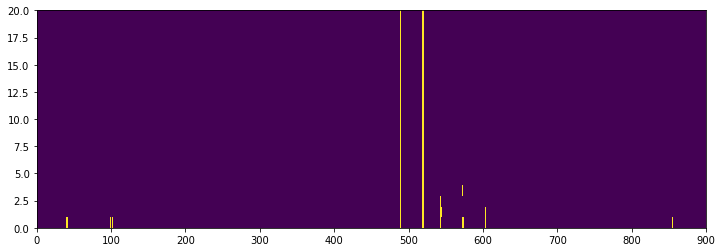

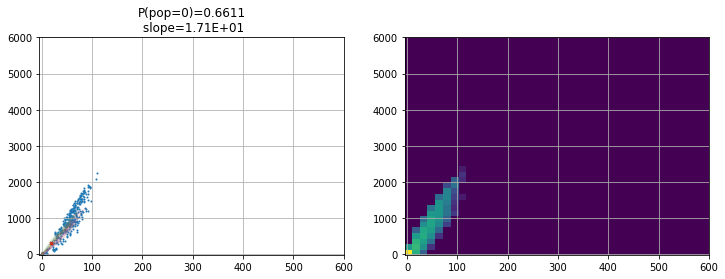

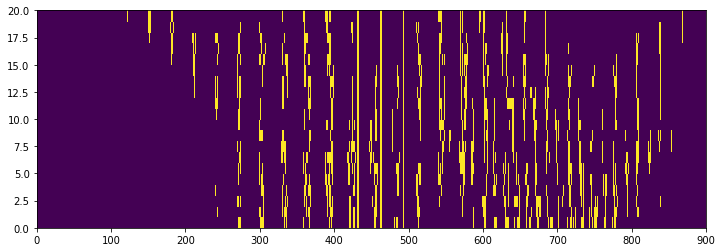

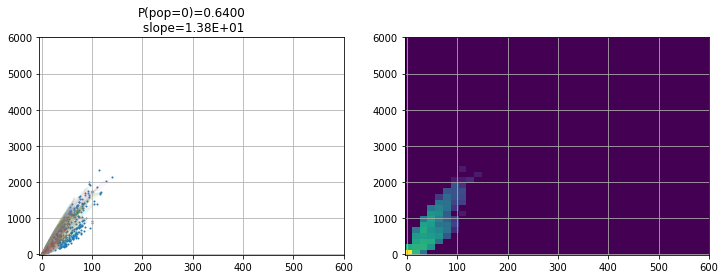

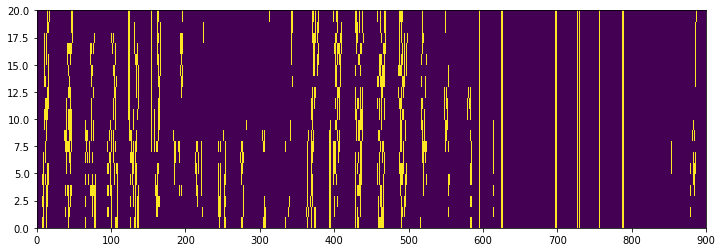

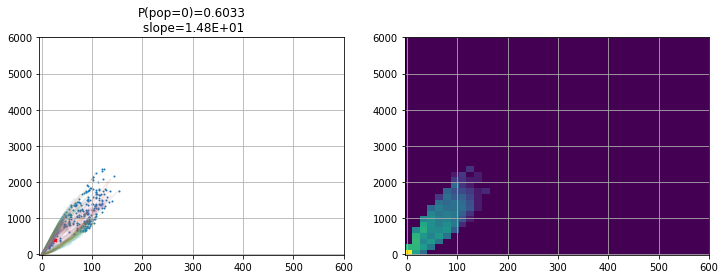

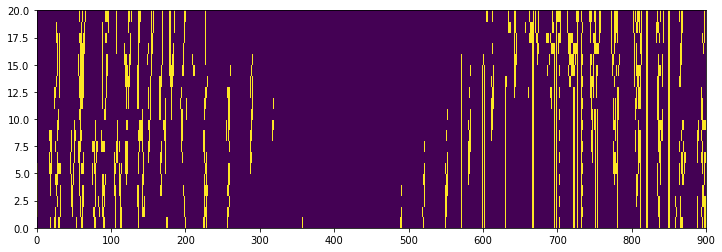

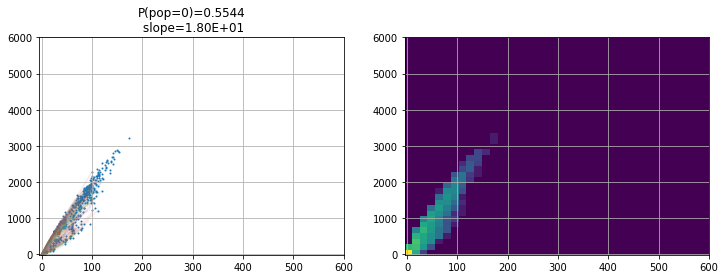

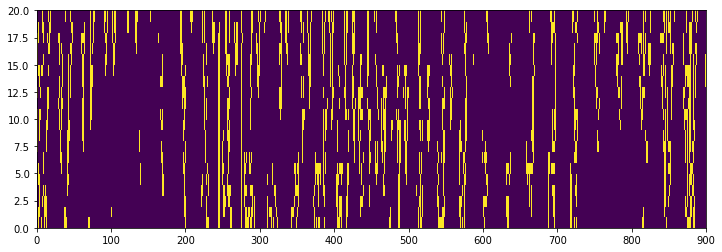

In [243]:
for i in range(5):
    pop,drift,real,defect = worker(tst_dct[32])
    plotter(pop,drift)
    plt.show()
    showsptime(real)
    plt.show()


In [218]:
defect.shape

(20, 900, 30, 30)

In [222]:
animate()

In [169]:
lview(guess(dct=tst_dct[10]))

http://newflaw.com/view.php?rule_alias=b1ce03acijkry2aeik5cijknry4cik7ce6aekn8s1c03aijkqry2akn5acijnqy4ainqrtwy7ce6cek8


'http://newflaw.com/view.php?rule_alias=b1ce03acijkry2aeik5cijknry4cik7ce6aekn8s1c03aijkqry2akn5acijnqy4ainqrtwy7ce6cek8'

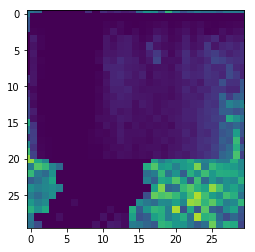

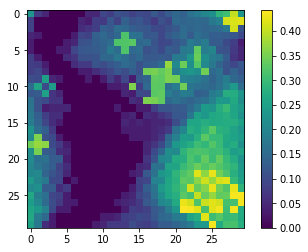

In [242]:
# for i in range(32):
i = 8
if 1:
    pop,drift,real,defect = worker(tst_dct[i])
    showsptime(sflatten(defect.mean(axis=1)))
    dmat =dmat_l1(real)
#     showsptime( (dmat*defect).std(axis=1)[-1])
#     showsptime( r)
#     showsptime( real[0,0])
#     showsptime(sexpand(pop)[-1])
    plt.imshow(sexpand(pop)[-1])
#     showsptime( (defect).mean(axis=1)[-1])
    plt.show()
    plt.imshow( (defect).std(axis=1)[-1])
    plt.colorbar()
    plt.show()
#     driftsexpand()
#     plotter(pop,drift)

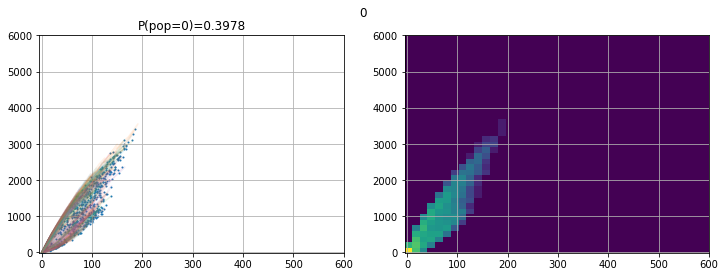

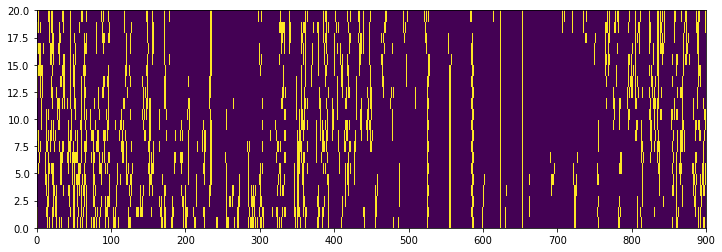

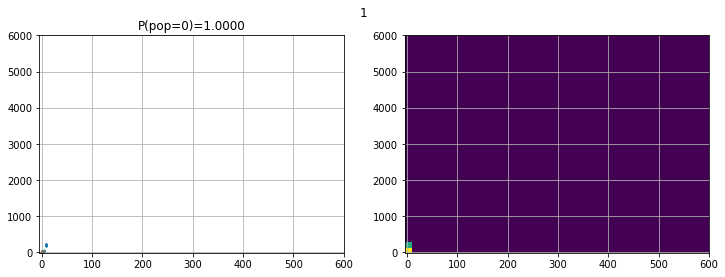

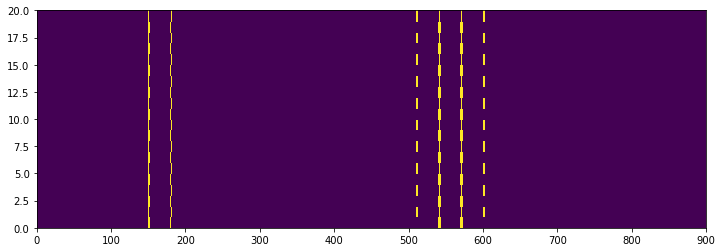

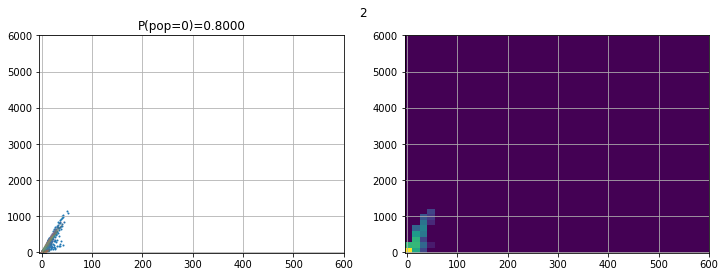

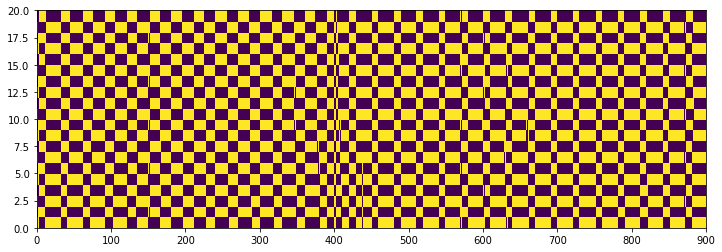

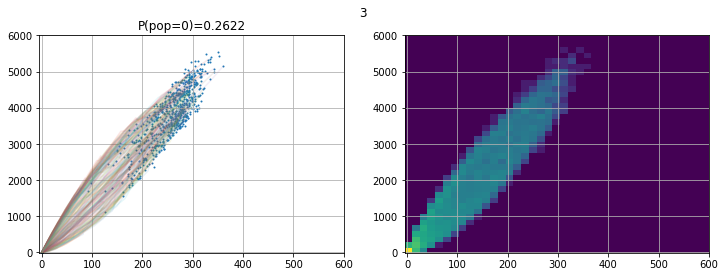

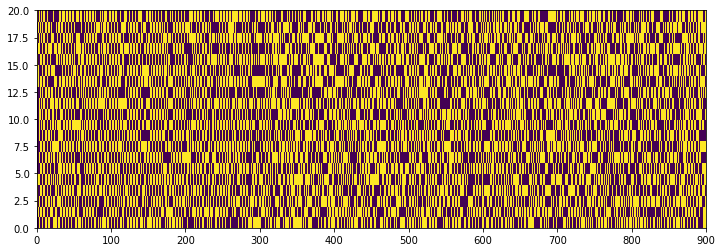

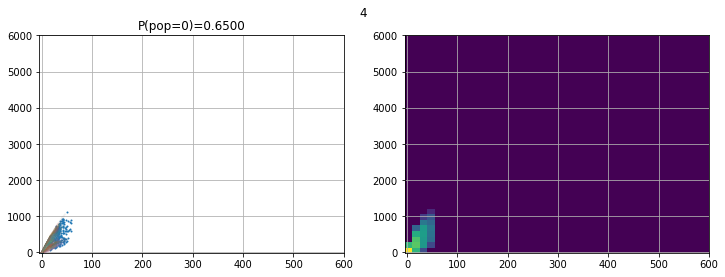

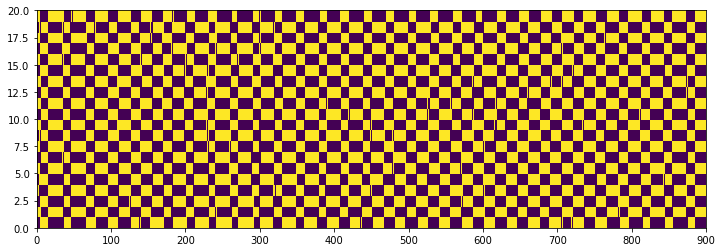

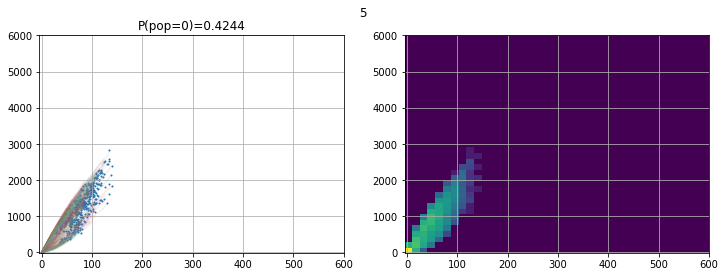

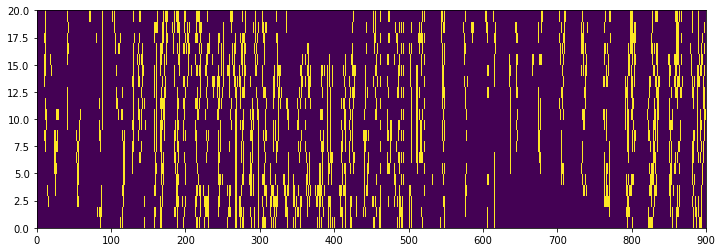

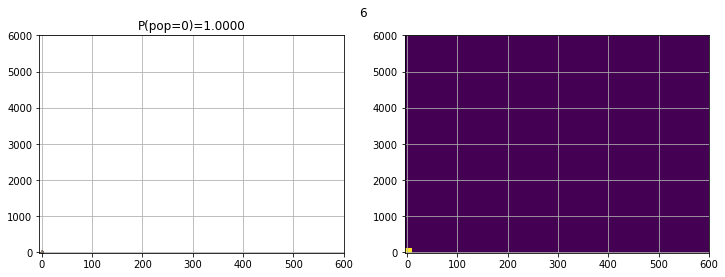

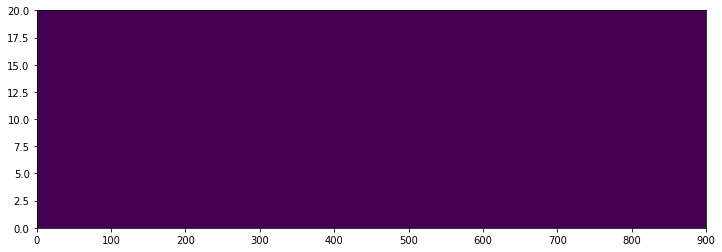

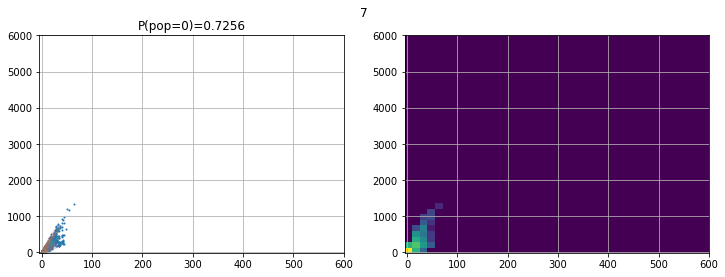

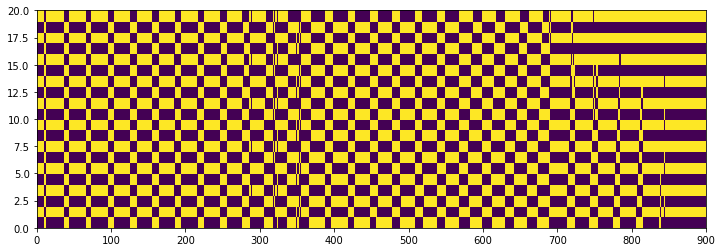

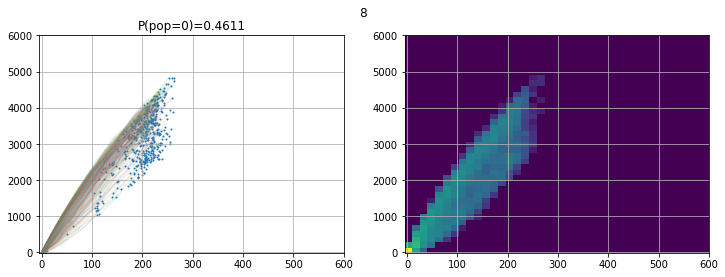

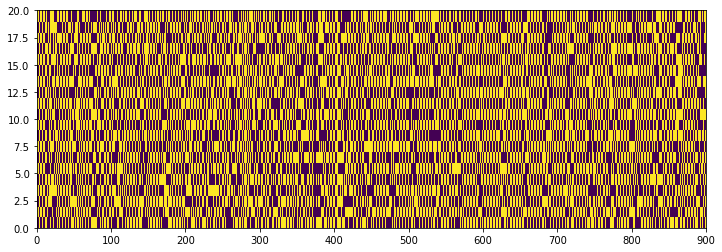

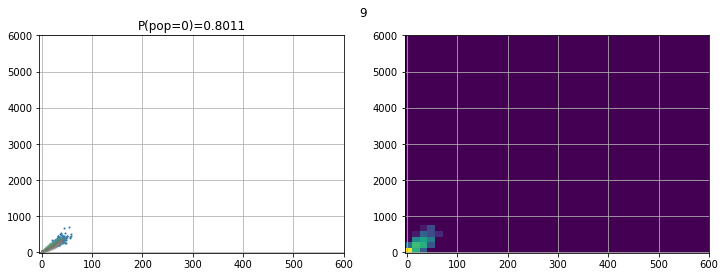

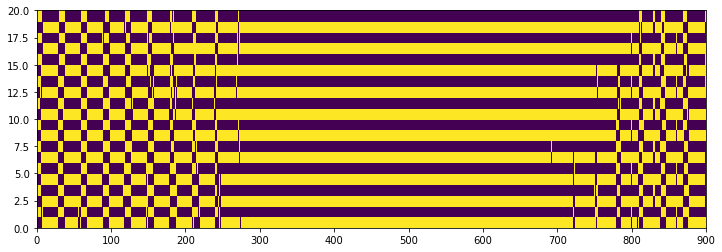

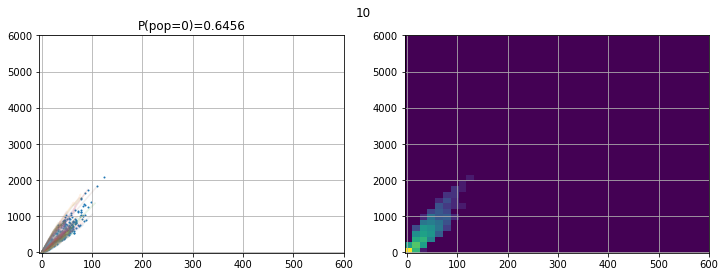

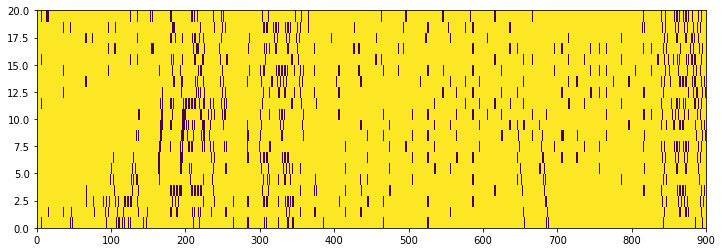

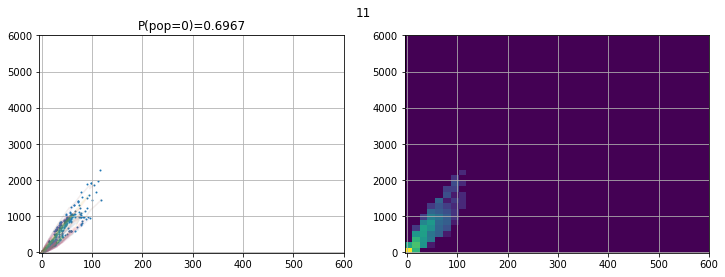

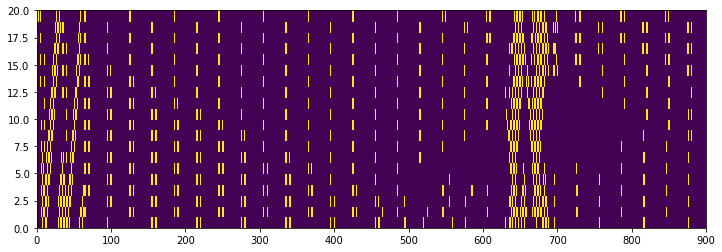

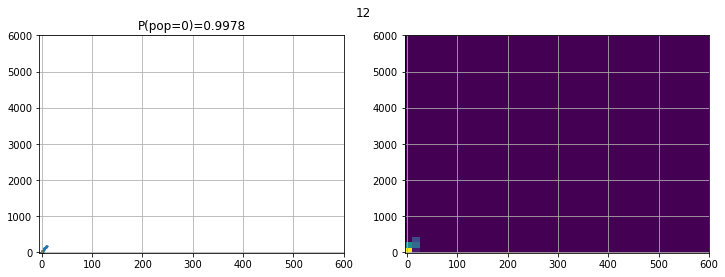

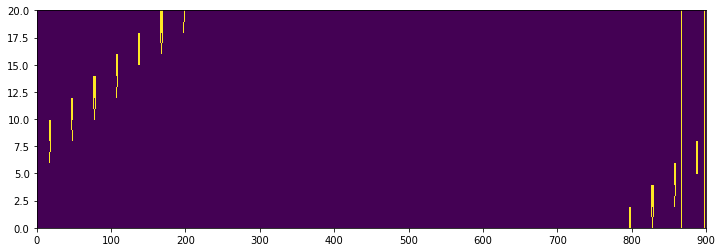

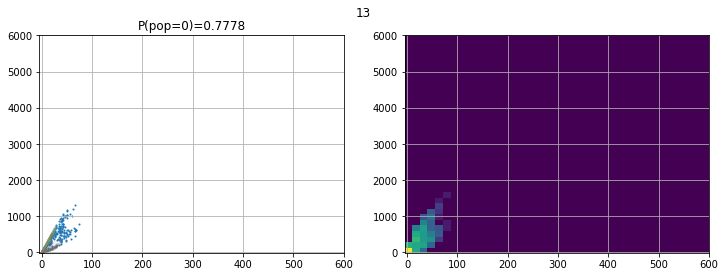

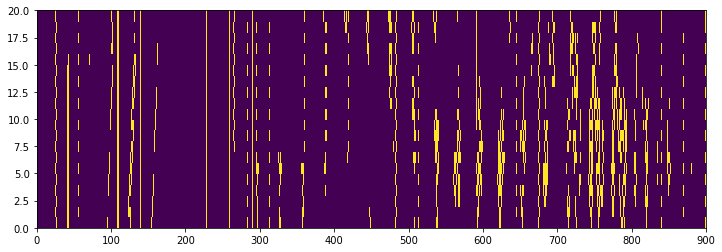

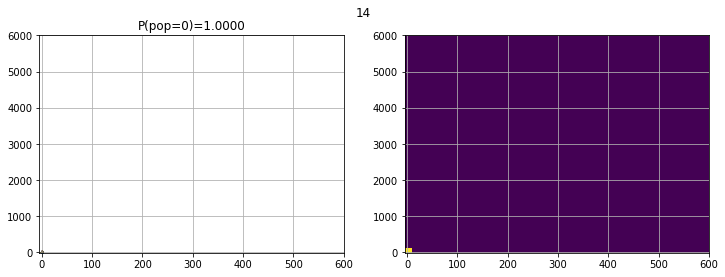

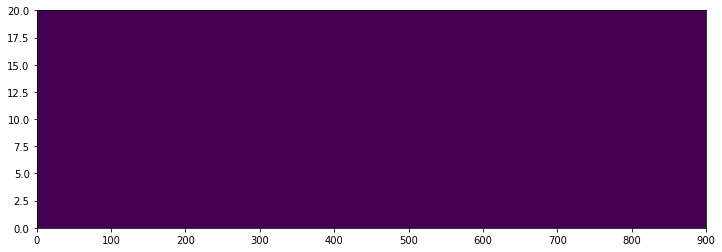

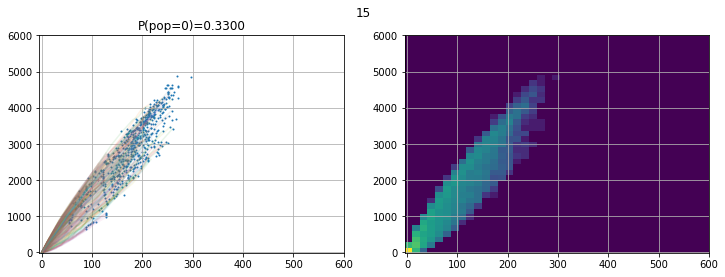

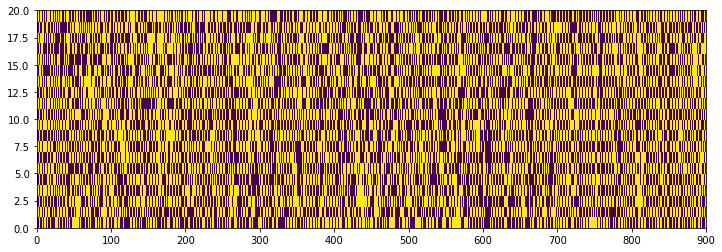

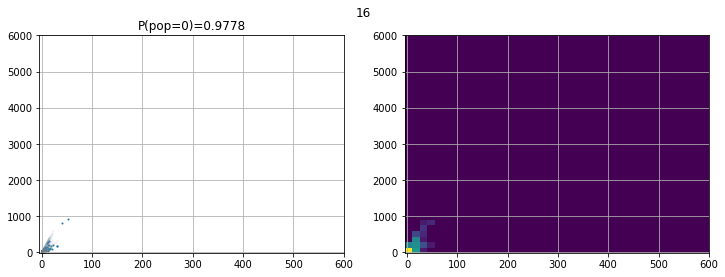

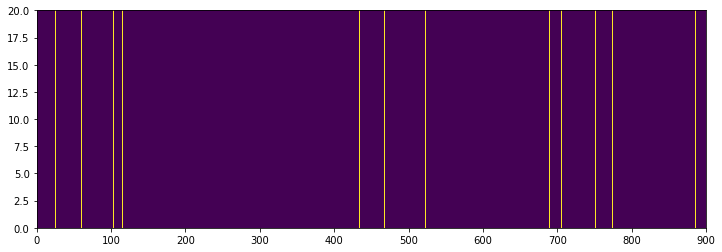

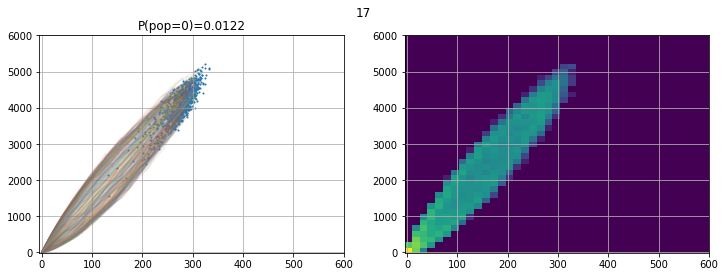

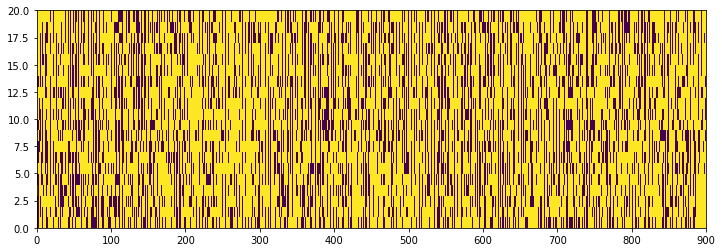

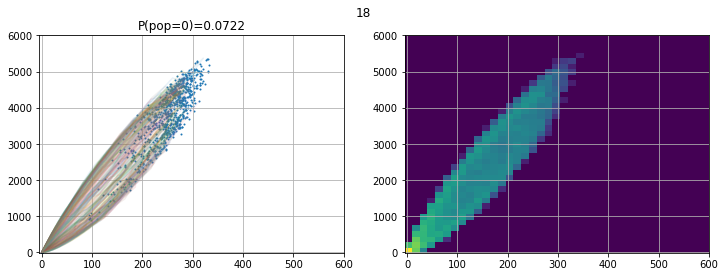

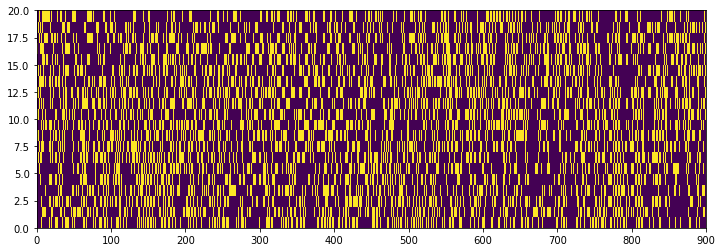

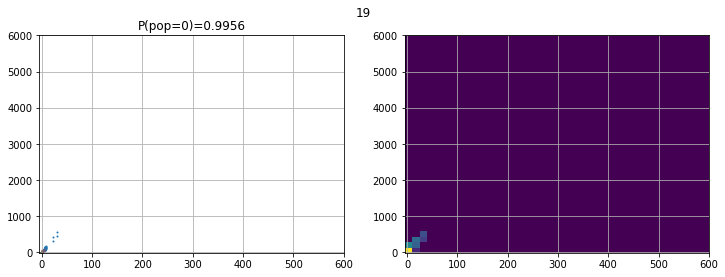

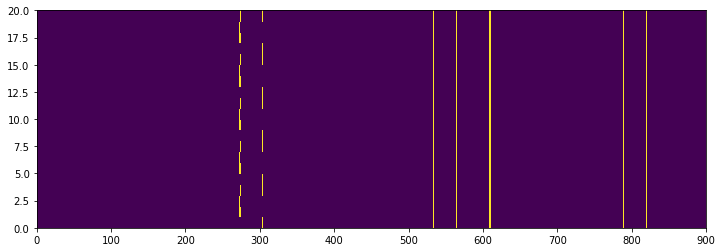

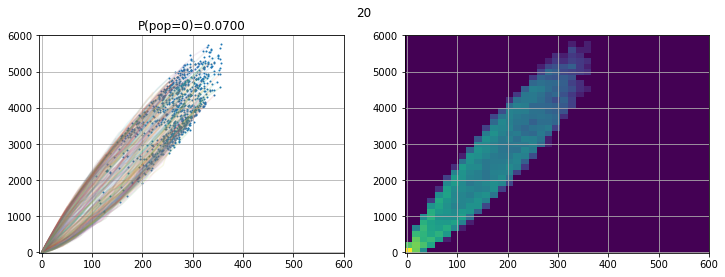

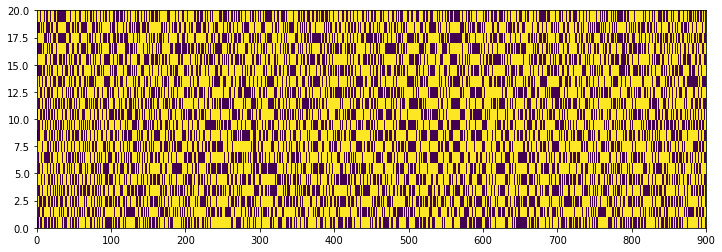

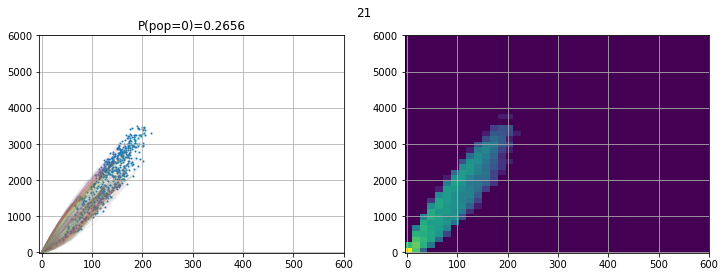

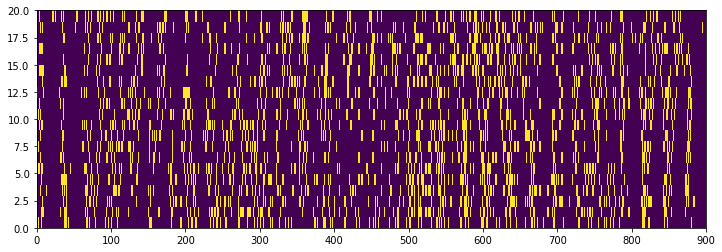

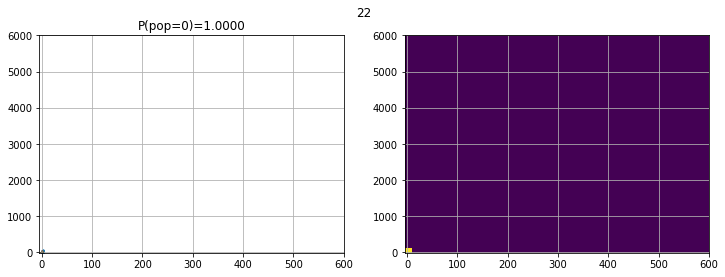

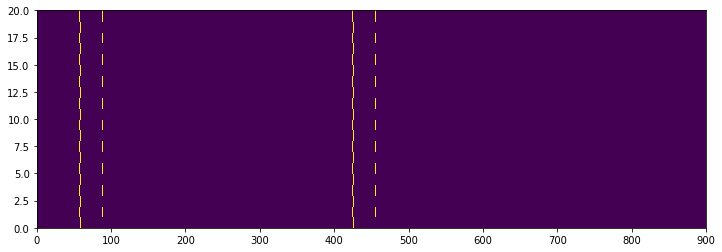

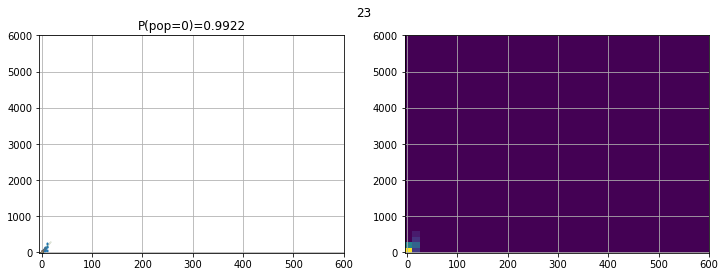

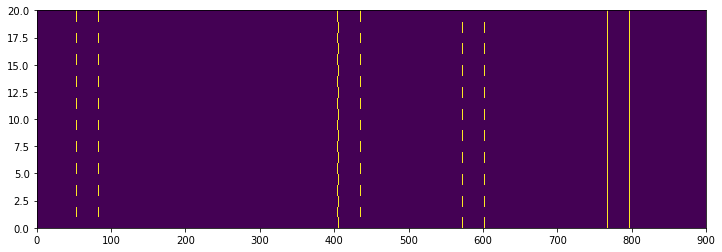

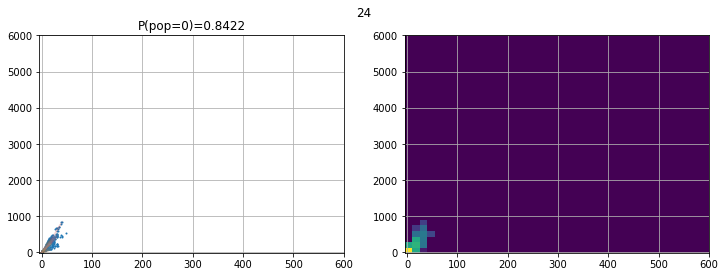

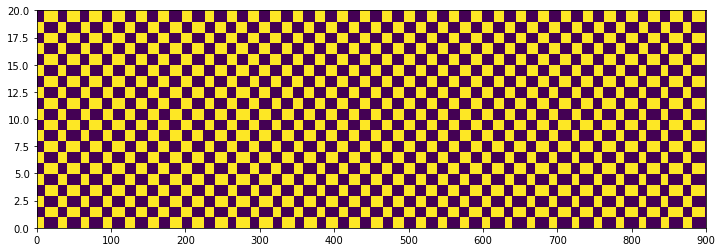

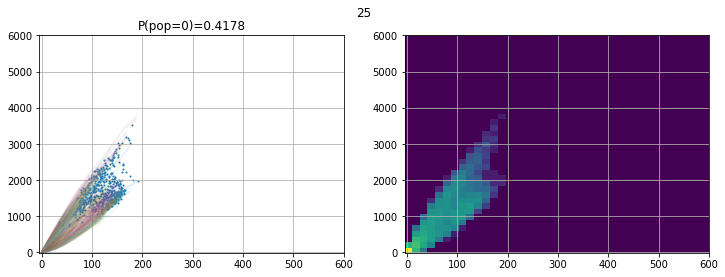

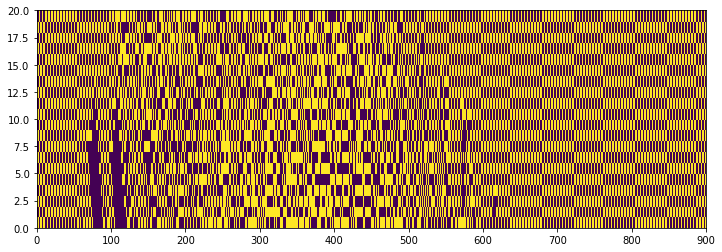

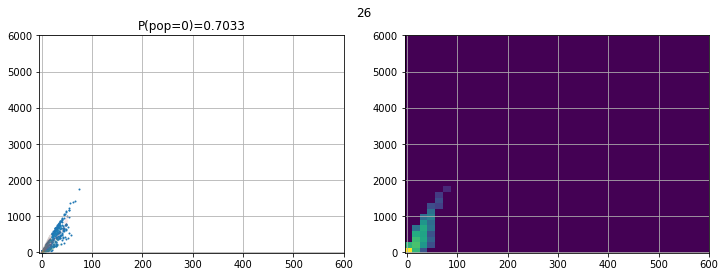

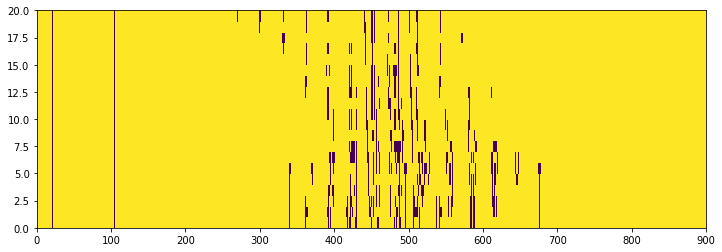

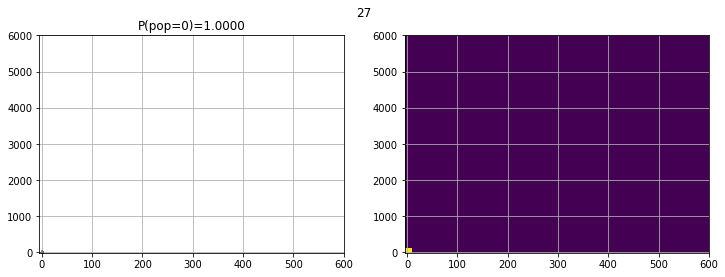

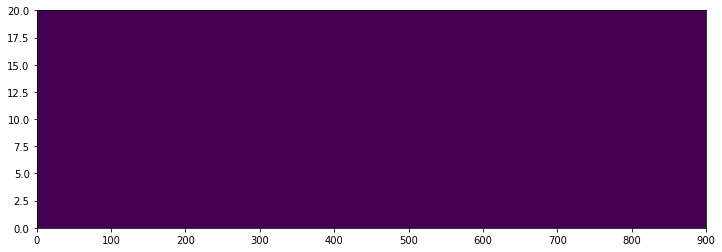

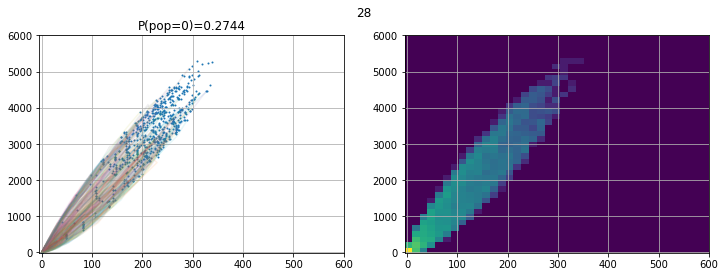

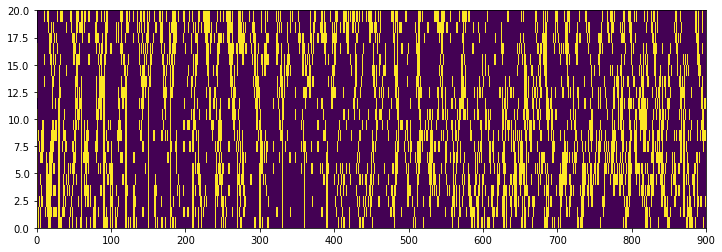

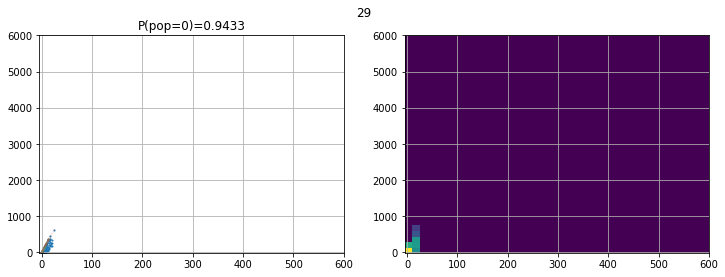

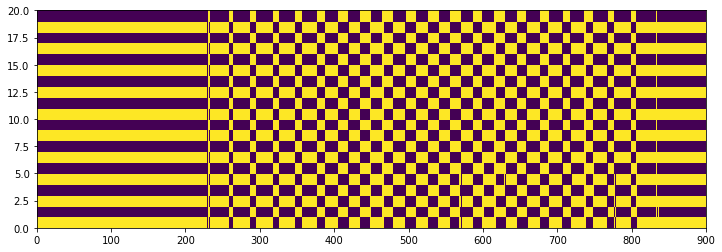

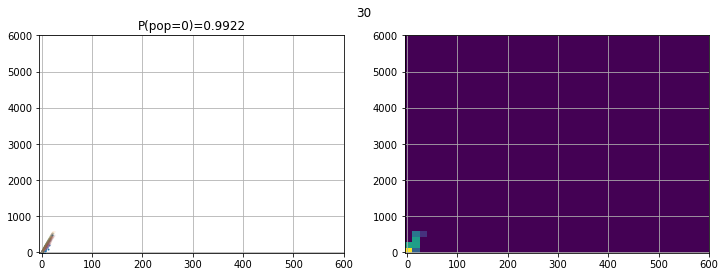

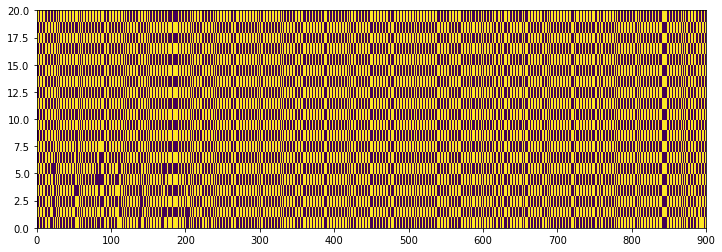

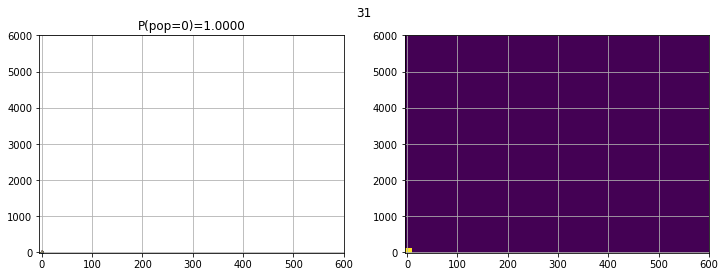

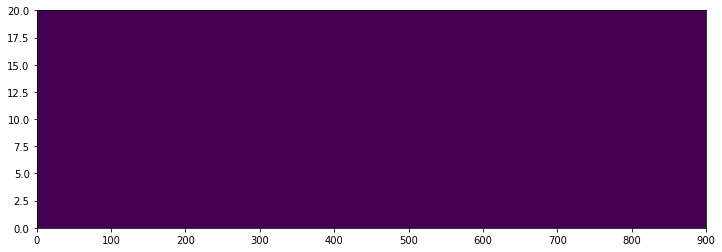

In [209]:
for i in range(32):
    pop,drift,real,defect = worker(tst_dct[i])
    plotter(pop,drift)
    plt.suptitle(i)
    plt.show()
    showsptime(real)
    plt.show()


In [170]:
lview(guess(dct = tst_dct[25]))

http://newflaw.com/view.php?rule_alias=b1c03ceinqr2akn5aejknqry4aeiyz7e6aceik8s03ck5cejqry4aceqrwyz7c6ei8


'http://newflaw.com/view.php?rule_alias=b1c03ceinqr2akn5aejknqry4aeiyz7e6aceik8s03ck5cejqry4aceqrwyz7c6ei8'

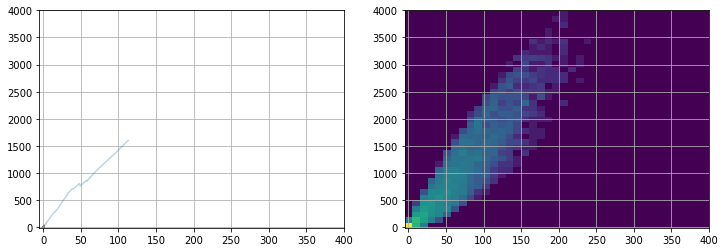

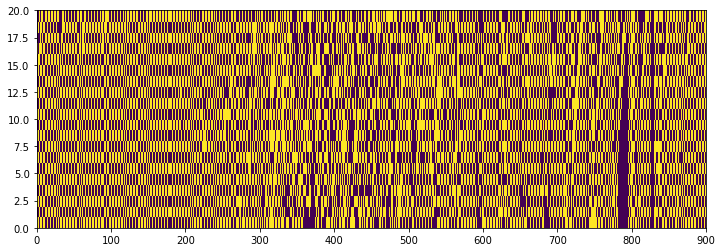

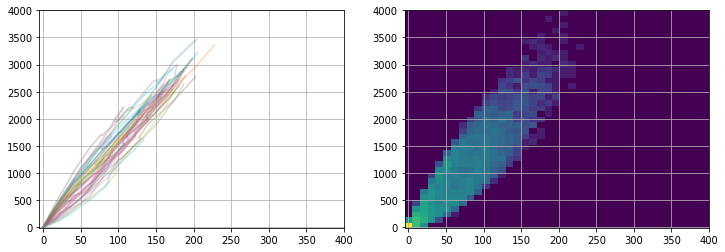

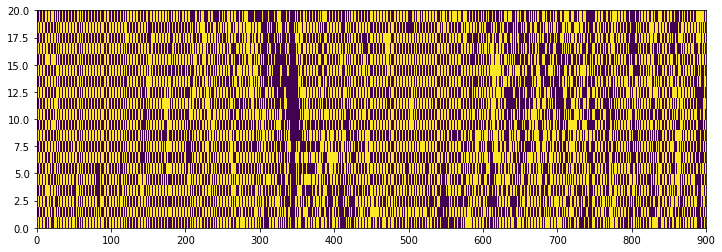

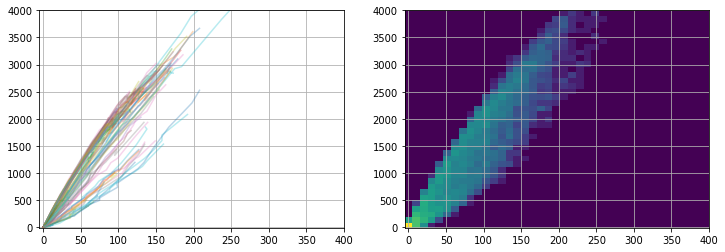

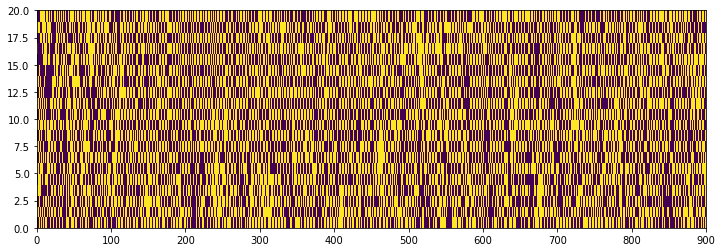

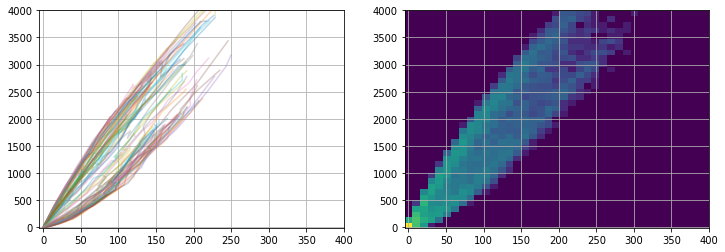

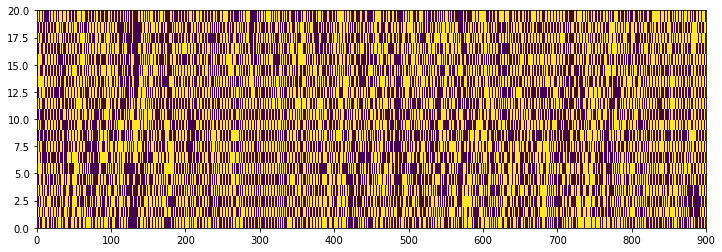

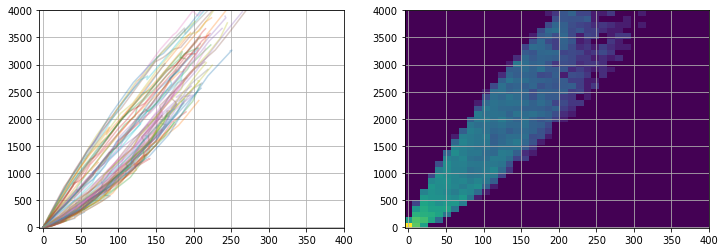

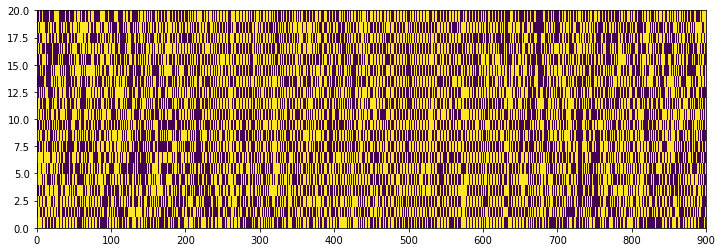

In [146]:
for i in range(5):
    pop,drift,real = worker(tst_dct[15])
    plotter(pop,drift)
    plt.show()
    showsptime(real)
    plt.show()


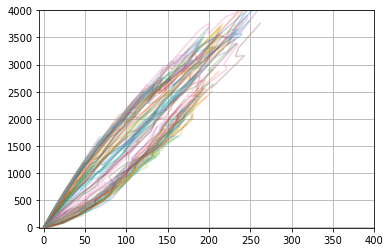

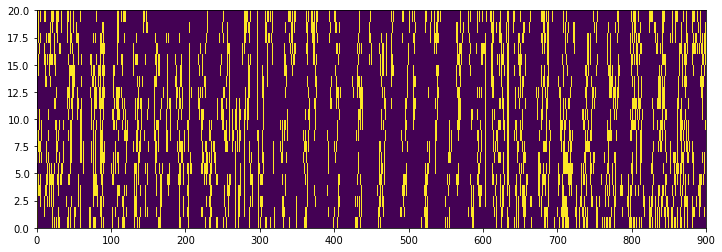

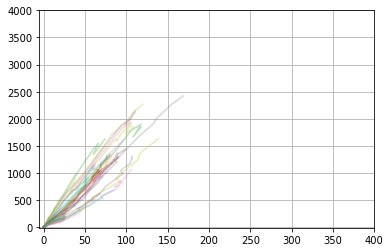

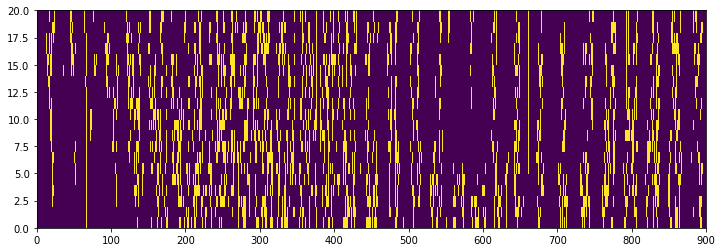

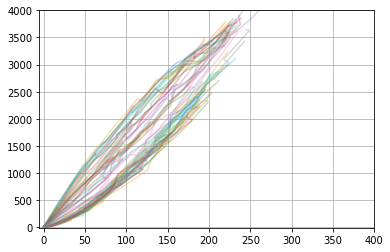

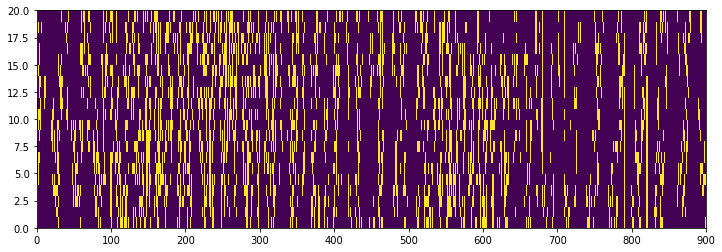

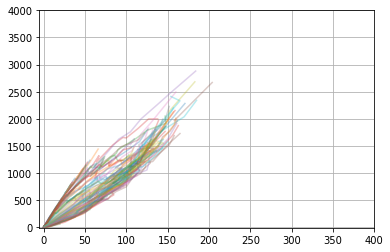

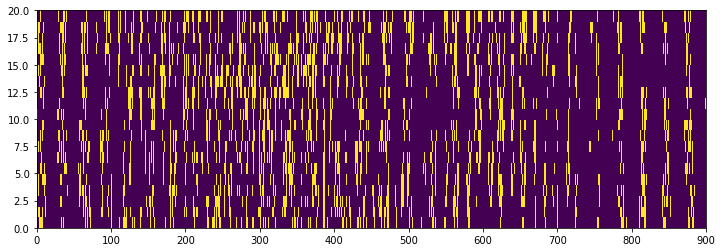

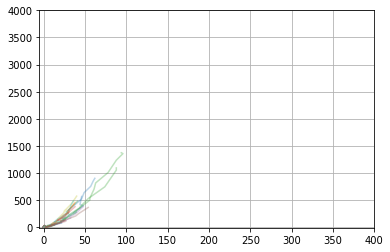

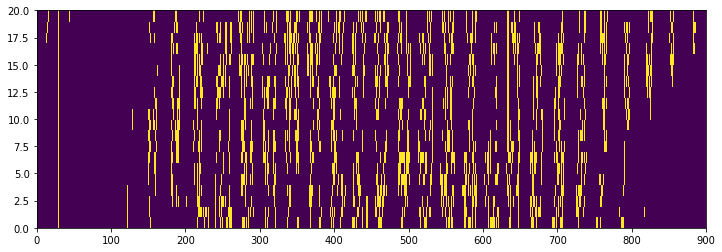

In [119]:
for i in range(5):
    pop,drift,real = worker(tst_dct[5])
    plotter(pop,drift)
    plt.show()
    showsptime(real)
    plt.show()


{'alias': 'b3aeikq2ce5c4aeikws1ce3aceijknqry7ce6aceikn', 'rulestr': u'0c83820e0060061941946a68f0', 'family': '2dntca'}


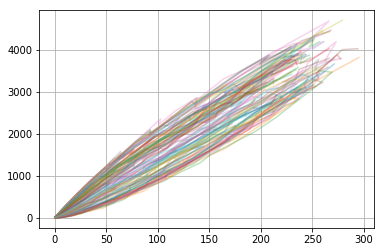

In [71]:
N = 100
plt.plot(pop[:,:N],drift[:,:N],alpha=0.3)
print env.as_config()
plt.grid()
plt.show()

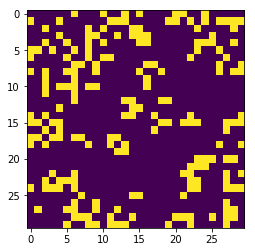

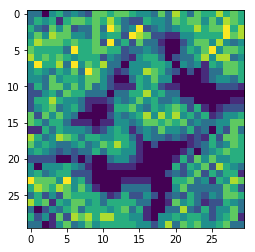

In [62]:
# showsptime()
plt.imshow(ini[0])
plt.show()
plt.imshow(sexpand(pop)[1])
plt.show()

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in divide
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in divide
/home/shouldsee/.local/lib/python2.7/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/shouldsee/.local/lib/python2.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/shouldsee/.local/lib/python2.7/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


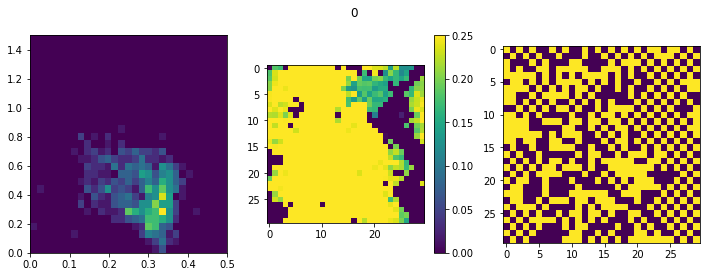

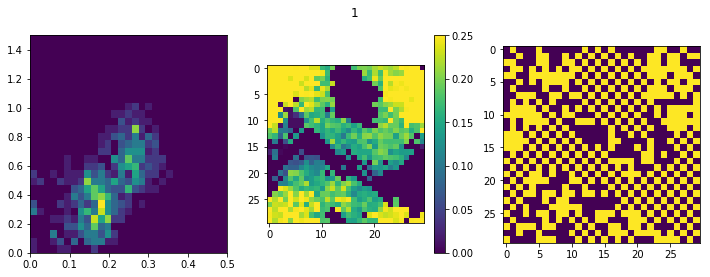

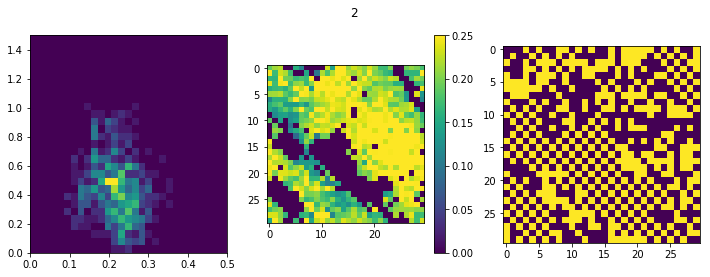

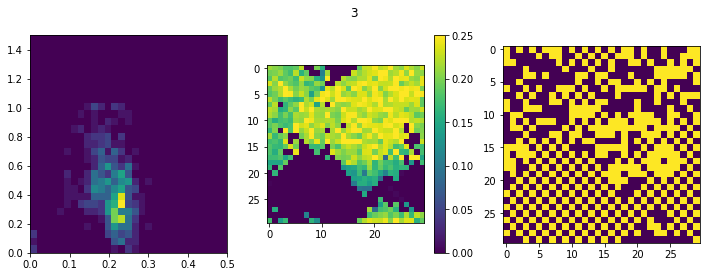

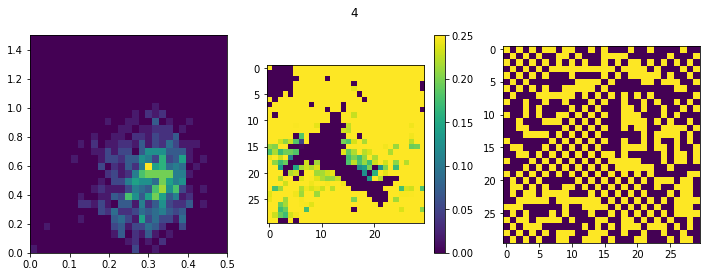

In [5]:
from KBs import *
def mutate(avc,idx,orig=1):
# if 1:
#     idx = np.array(idx)
    nsp = len(idx)
#     out = KBs.sample(env)
#     cmap = plt.get_cmap('rainbow')

    loc = np.vstack([
#         [0]*nsp,
                     range(0,nsp),
                    zip(*idx)]
                   )
    idx = np.ravel_multi_index(loc, (nsp,)+avc.shape[1:] )
    real = avc
    dev = np.repeat(real.copy(),nsp,axis=0)
    dev.flat[idx]=1-dev.flat[idx]
    if orig:
        dev = np.vstack([real,dev])
    return dev

def main(t=20,**kwargs):
    env = KBs.guess(**kwargs)
    env.change_size((20, 100, 30**2))
    ini = sample(env)[-1][0:1]
    L = ini.shape[-1]
    # idx = idx + np.array([[L//2,L//2]])
    idx = np.meshgrid(range(L),range(L))
    idx = zip(*[x.ravel() for x in idx])
    mut = mutate(ini,idx)

    out = sample(env,ini=mut)
    out = out[:50]
    SUM = out[:,1:] + out[:,0:1]
    flaw = SUM==1
    tSUM = (flaw).mean(axis=0)

    # imlstshow(tSUM[:5])
    # plt.show()
    fc = flaw[t:t+1]
    fN = fc.sum(axis=(2,3))
    c = fN/(L**2.)

    X = np.arange(0,L)
    X,Y = np.meshgrid(X,X)
    X[None,None]
    Xs = fc*X[None,None]
    Ys = fc*Y[None,None]
    Xm=abs(Xs.sum(axis=(2,3)).astype(float)/fN- X.T.ravel()[None])
    Ym=abs(Ys.sum(axis=(2,3)).astype(float)/fN- Y.T.ravel()[None])
    dN = np.minimum(Xm,L-Xm) + np.minimum(Ym,L-Xm)    
    
    BINS=np.linspace(0,0.15,20)
    fig,axs=plt.subplots(1,3,figsize=[12,4])
    plt.sca(axs[0])
#     plt.scatter(fN.ravel()/L**2.,dN.ravel()/L)
    plt.hist2d(fN.ravel()/(L**2.),dN.ravel()/L,
               bins=[np.linspace(0,0.5,30),    np.linspace(0,1.5,30)]
#                bins=[np.linspace(0,0.5,30),    np.linspace(0,1,30)]
              )
#     plt.hist(c.ravel(),bins=BINS,normed=1)
#     plt.ylim(0,50)
    # plt.xlim([0,])
    # plt.imshow((sexpand(dN))[0].T*(ini[0]-0.5))
    plt.sca(axs[1])
    # plt.imshow((sexpand(c))[0].T*(ini[0]-0.5),vmin=-.125,vmax=(t*0.5/L)**2)
    # plt.imshow((sexpand(c))[0].T*(ini[0]-0.5),vmin=0,vmax=(float(t)/L)**2)
    plt.imshow((sexpand(c))[0].T,vmin=0,vmax=0.25)

    # plt.imshow((sexpand(c))[0].T*(ini[0]-0.5),vmin=0)

    plt.colorbar()
    plt.sca(axs[2])
    plt.imshow(ini[0])
#     plt.show()
# map(lambda x:main(dct=x),tst_dct)
for i in range(5):
    main(dct=tst_dct[8])
    plt.suptitle(i)
    plt.show()